# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import scipy.io as sio
import time
import cv2
import matplotlib.cm as cm
from os import listdir
from PIL import Image
from numpy import asarray
from os.path import dirname, join as pjoin

# Import Dataset - Crowd counting

## UCSD Dataset

UCSD dataset consists of an hour of video with 2000 annotated frames and in a total of 49,885 pedestrian
instances, which was captured from a pedestrian walkway of the UCSD campus by a stationary camera. The original video was recorded at 30fps with a frame size of 480 × 740 and later downsampled to 10fps with dimension 158×238. The 601-1400 frames were used for training and the remaining 1200 frames for testing. 
The ROI of the walkway and the traveling direction are
also provided.

It is taken from http://www.svcl.ucsd.edu/projects/peoplecnt/

### Images

In [3]:
def load_dataset(path_vidf):
    full_lista = []
    for path in os.listdir(path_vidf):
        lista_images = []
        # Append images to a list
        for item in os.listdir(path_vidf+path+"/"):
            if os.path.isfile(path_vidf+path+"/"+item):
                im = Image.open(path_vidf+path+"/"+item).convert("RGB")
                im = np.array(im)
                lista_images.append(im)
        full_lista.append(np.array(lista_images))
    return full_lista

In [5]:
UCSD_dataset = load_dataset("Dataset/UCSD/vidf/")

In [6]:
# Convert and save the list of images in '.npy' format
np.save("images_UCSD.npy", UCSD_dataset)

In [7]:
images_UCSD = np.load("images_UCSD.npy")
images_UCSD.shape

(10, 200, 158, 238, 3)

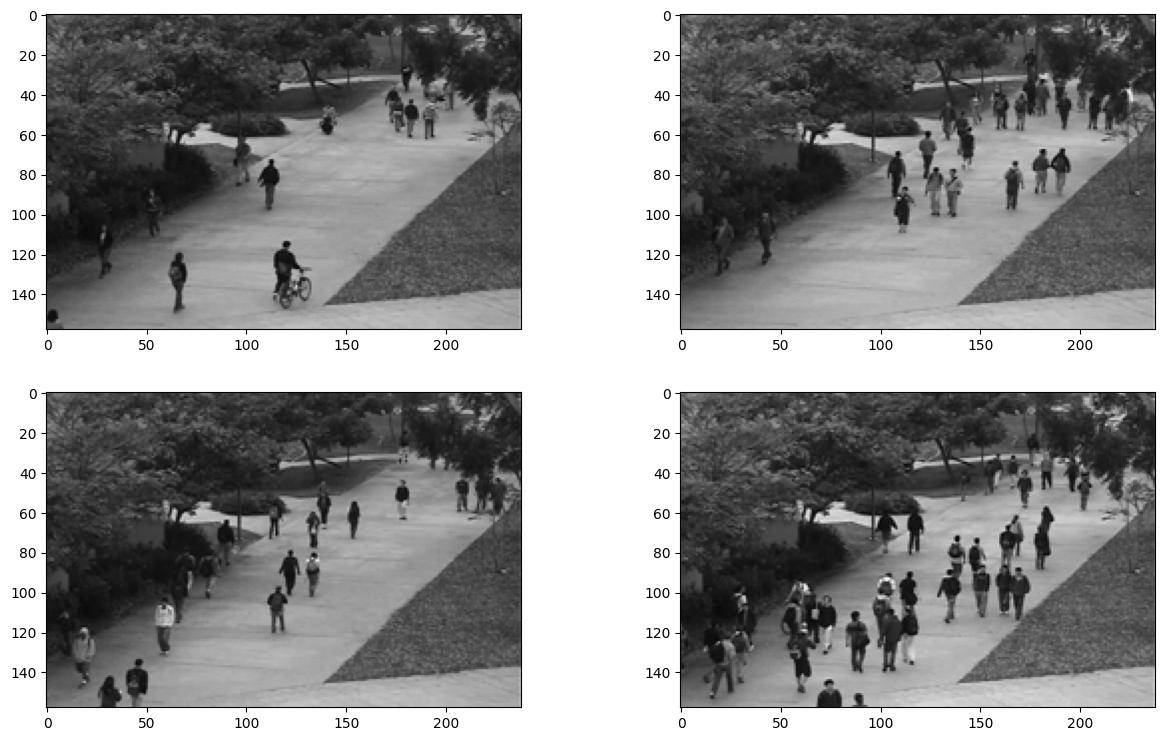

In [8]:
# lest's display 4 images

f, ax = plt.subplots(2,2, figsize = (15, 9))

ax[0,0].imshow(images_UCSD[0][0])
ax[0,1].imshow(images_UCSD[2][0])
ax[1,0].imshow(images_UCSD[5][0])
ax[1,1].imshow(images_UCSD[6][0])


### Labels

In [13]:
def read_mat_label(path):
    labels = []
    for item in os.listdir(path):
        if os.path.isfile(path+item) & (item.endswith(".mat")):
            dict_label = sio.loadmat(path+item)
            labels.append(dict_label["count"])
    counts = [np.sum(labels[i], axis=1)[0] for i in range(len(labels))]  # sum of right and left counts
    return counts

In [14]:
labels_UCSD = read_mat_label("Dataset/UCSD/vidf-cvpr/")

In [15]:
# Convert and save the list of images in '.npy' format
np.save("labels_UCSD.npy", labels_UCSD)

In [16]:
labels_UCSD = np.load("labels_UCSD.npy")
labels_UCSD.shape

(10, 1, 200)

## Mall Dataset

Mall dataset was captured by a public surveillance camera in a shopping mall, which contains more challenging lighting conditions and more severe perspective distortion than the UCSD dataset. 
The dataset is composed by RGB images of frames in a video (as inputs) and the object counting on every frame, this is the number of pedestrians (object) in the image. The images are 480x640 pixels at 3 channels of the same spot recorded by a webcam in a mall but it has different number of person on every frame, is a problem of crowd counting.

It is taken from https://www.kaggle.com/datasets/fmena14/crowd-counting?resource=download&select=labels.csv

In [2]:
# 2000 RGB images of 480x640 pixels
images_MALL = np.load("Dataset/Mall/images.npy")
images_MALL.shape

(2000, 480, 640, 3)

Number of people: 29


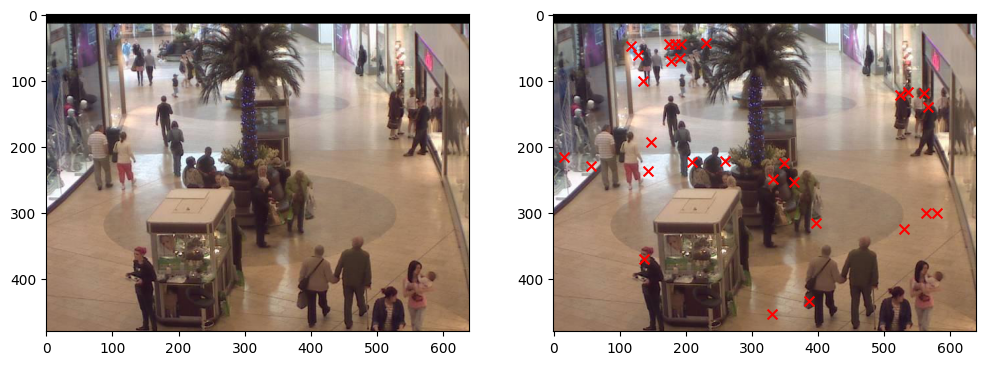

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(images_MALL[0])
plt.subplot(1, 2, 2)
plt.imshow(images_MALL[0])
print(f"Number of people: {len(gt_MALL['frame'][0, 0][0, 0][0])}")

for x,y in gt_MALL["frame"][0, 0][0, 0][0]:
    plt.scatter(round(x),round(y), s = 50, marker = "x", color = "r")

Number of people: 30


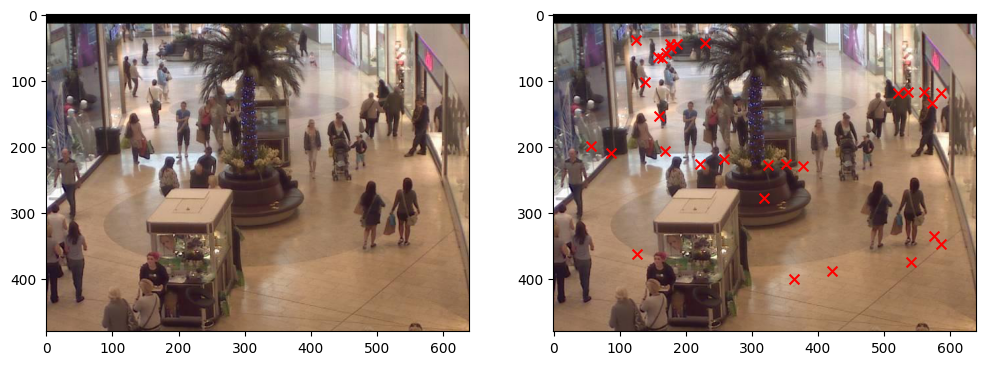

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(images_MALL[1])
plt.subplot(1, 2, 2)
plt.imshow(images_MALL[1])
print(f"Number of people: {len(gt_MALL['frame'][0, 1][0, 0][0])}")

for x,y in gt_MALL["frame"][0, 1][0, 0][0]:
    plt.scatter(round(x),round(y), s = 50, marker = "x", color = "r")

In [ ]:
gt_MALL = sio.loadmat("Dataset/Mall/mall_dataset/mall_gt.mat")
gt_MALL["frame"][0, 1][0,0][0]

In [56]:
def density_map(img, gt, i):
    output = np.zeros(img[i].shape[:-1])
    x = gt["frame"][0, i][0, 0][0][:,0] # da sistemare perché nel mio caso 0, i è l'immagine nuova
    y = gt["frame"][0, i][0, 0][0][:,1]
    
    for x_choord, y_choord in zip(x, y):
        density_i = np.zeros(img[i].shape[:-1])
        try:
            density_i[round(y_choord),round(x_choord)] = 1
        except:
            pass
        nearest_distance = np.min(np.linalg.norm(x_choord - y_choord))
        sigma = 0.3 * nearest_distance # beta = 0.3 suggested by MCNN paper
        kernel_size = 3
            
        density_i = cv2.GaussianBlur(density_i, (kernel_size,kernel_size), sigma)
        output += density_i
    return cv2.GaussianBlur(output, (51,51), sigma)

In [57]:
density_map(images_MALL, gt_MALL, 0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

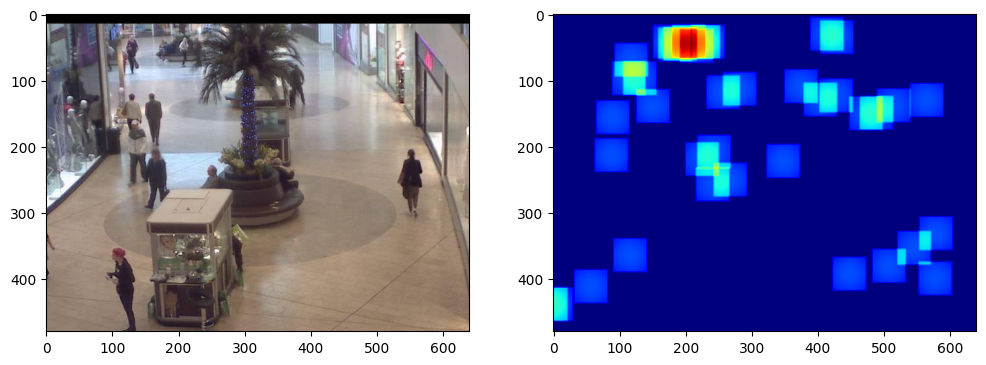

In [62]:
ds_map = density_map(images_MALL, gt_MALL, 10)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(images_MALL[10])
plt.subplot(1, 2, 2)
_=plt.imshow(ds_map , cmap = cm.jet)

In [29]:
density_map(images_MALL[0], gt_MALL["frame"][0, 0][0, 0][0])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Time: 0.09949421882629395


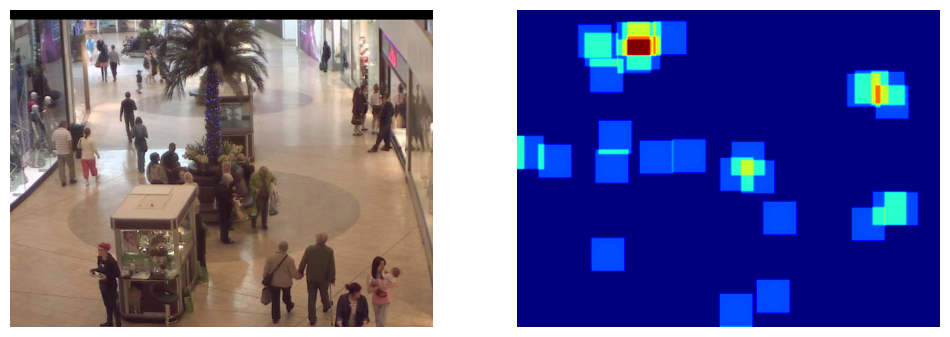

In [20]:
start = time.time()
ds_map = density(img[i], gt_MALL["frame"][0, 0][0, 0][0])
print(f"Time: {time.time() - start}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(images_MALL[0])
plt.subplot(1, 2, 2)
plt.axis("off")
_=plt.imshow(ds_map , cmap = cm.jet)

(0.0, 1.0, 0.0, 1.0)

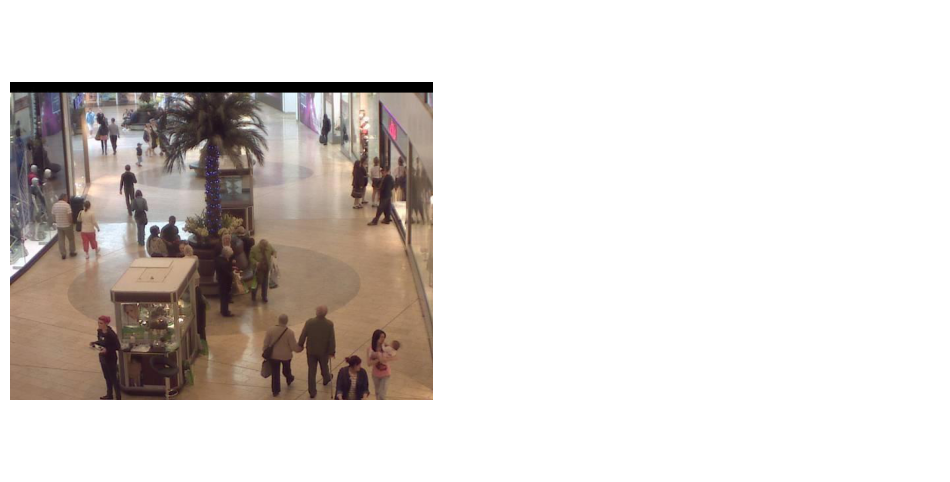

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(images_MALL[0])
plt.subplot(1, 2, 2)
plt.axis("off")
# _=plt.imshow(ds_map , cmap = cm.jet)

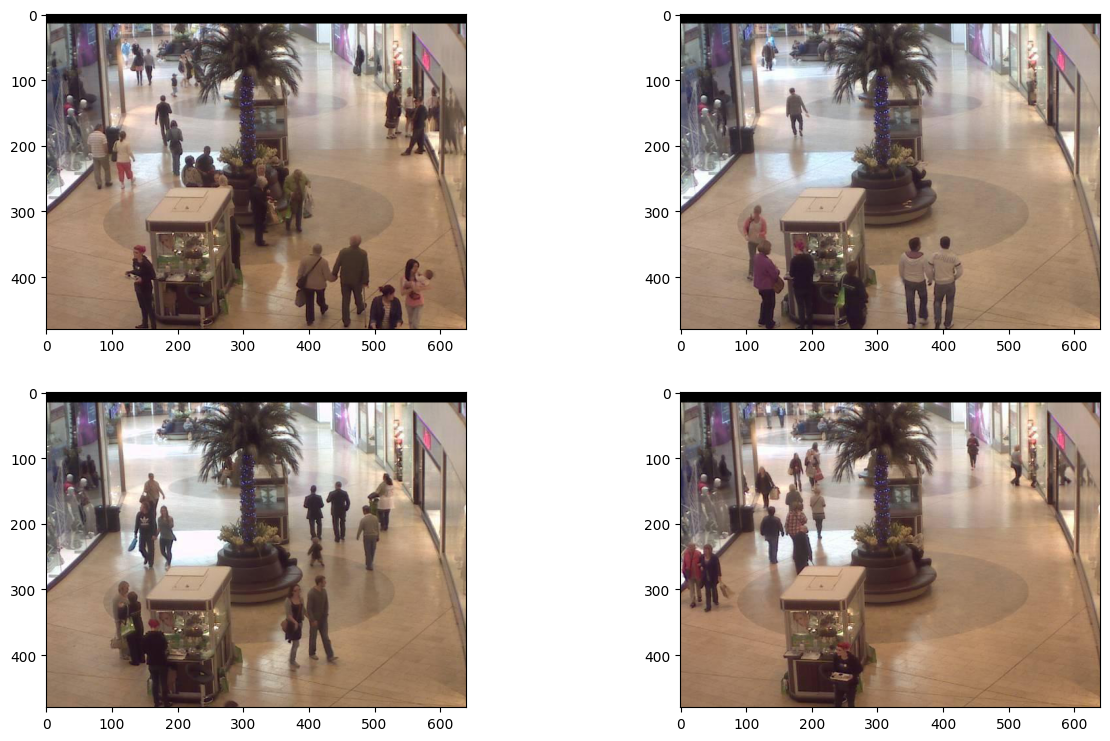

In [8]:
# lest's display 4 images

f, ax = plt.subplots(2,2, figsize = (15, 9))

ax[0,0].imshow(images_MALL[0])
ax[0,1].imshow(images_MALL[15])
ax[1,0].imshow(images_MALL[30])
ax[1,1].imshow(images_MALL[45])

## Fudan-ShanghaiTech Dataset

Fudan-ShanghaiTech is a large-scale video crowd counting dataset that has been introduced because existing video crowd counting datasets were too small in terms of number of both frames as well as scenes.

It contains 100 videos captured from 13 different scenes. FDST includes 150,000 frames and 394,081 annotated heads. The training set of the FDST dataset consists of 60 videos, 9000 frames, and the testing set contains the remaining 40 videos, 6000 frames. The number of frames per second (FPS) for FDST is 30.

It is taken from https://github.com/sweetyy83/Lstn_fdst_dataset

In [49]:
# To check the resolution of the images in a folder
for n in range(1, 151):
    for i in os.listdir("Dataset/FDST/train_data"):
        print(i, Image.open("Dataset/FDST/train_data/" + i + "/" + "%.3d" % n + ".jpg").size)

1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1

33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1

87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (

11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (

68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1

98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1

92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (

16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1

63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (

97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1

38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (12

63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (

21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (

33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1

82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (1920, 1080)
88 (1920, 1080)
91 (1920, 1080)
92 (1920, 1080)
93 (1920, 1080)
96 (1920, 1080)
97 (1920, 1080)
98 (1920, 1080)
1 (1920, 1080)
11 (1920, 1080)
12 (1920, 1080)
13 (1920, 1080)
16 (1920, 1080)
17 (1920, 1080)
18 (1920, 1080)
2 (1920, 1080)
21 (1920, 1080)
22 (1920, 1080)
23 (1920, 1080)
26 (1920, 1080)
27 (1920, 1080)
28 (1920, 1080)
3 (1920, 1080)
31 (1280, 720)
32 (1280, 720)
33 (1280, 720)
36 (1920, 1080)
37 (1920, 1080)
38 (1920, 1080)
41 (1280, 720)
42 (1280, 720)
43 (1280, 720)
46 (1920, 1080)
47 (1920, 1080)
48 (1920, 1080)
51 (1920, 1080)
52 (1920, 1080)
53 (1920, 1080)
56 (1920, 1080)
57 (1920, 1080)
58 (1920, 1080)
6 (1920, 1080)
61 (1920, 1080)
62 (1920, 1080)
63 (1920, 1080)
66 (1920, 1080)
67 (1920, 1080)
68 (1920, 1080)
7 (1920, 1080)
71 (1920, 1080)
72 (1920, 1080)
73 (1920, 1080)
76 (1920, 1080)
77 (1920, 1080)
78 (1920, 1080)
8 (1920, 1080)
81 (1920, 1080)
82 (1920, 1080)
83 (1920, 1080)
86 (1920, 1080)
87 (

In [50]:
def load_dataset_jpg(path_data):
    full_lista = []
    for path in os.listdir(path_data):
        lista_images = []
        # Append images to a list
        for item in os.listdir(path_data+path+"/"):
            if os.path.isfile(path_data+path+"/"+item) & (item.endswith(".jpg")) & (not item.startswith("._")):
                im = Image.open(path_data+path+"/"+item).convert("RGB")
                new_image = im.resize((640, 360))
                im = np.array(new_image)
                #print(f"Image: {item}, shape: {im.shape}")
                lista_images.append(im)
        full_lista.append(np.array(lista_images))    
    return full_lista

### Train dataset - 1

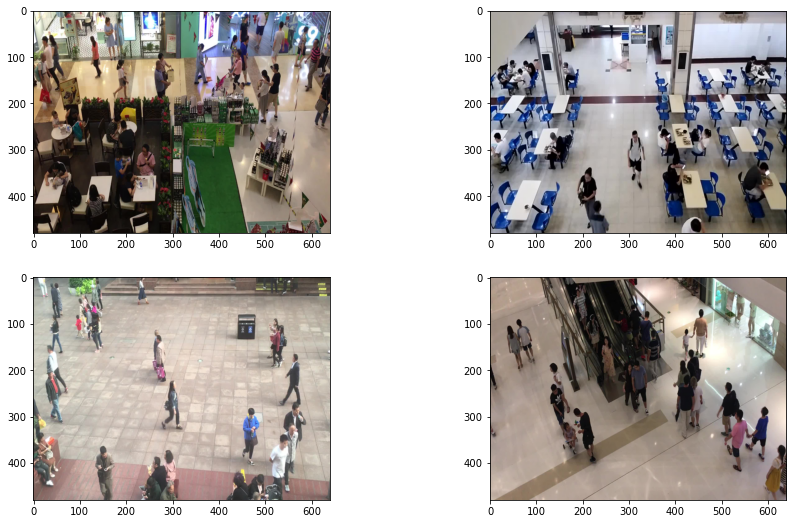

In [13]:
# lest's display 4 images

f, ax = plt.subplots(2,2, figsize = (15, 9))

ax[0,0].imshow(train_FDST1[0][0])
ax[0,1].imshow(train_FDST2[0][0])
ax[1,0].imshow(train_FDST3[0][0])
ax[1,1].imshow(train_FDST1[1][0])


### Test dataset - 1

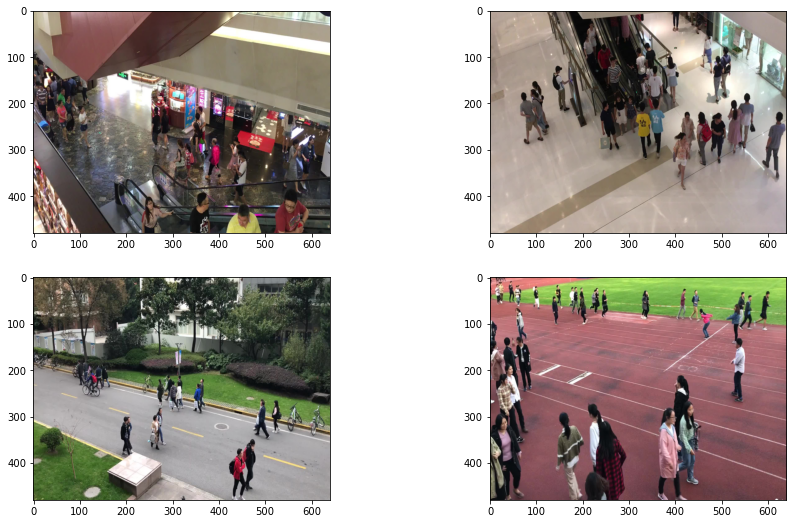

In [16]:
# lest's display 4 images

f, ax = plt.subplots(2,2, figsize = (15, 9))

ax[0,0].imshow(test_FDST1[0][0])
ax[0,1].imshow(test_FDST1[1][0])
ax[1,0].imshow(test_FDST2[0][0])
ax[1,1].imshow(test_FDST2[1][0])


## Labels FTSD

In [82]:
# To create a summary on all train (test) labels
myDict = {}
for i in os.listdir("Dataset/FDST/train_data"):
    subDict = {}
    for n in range(1, 151):
        f = open("Dataset/FDST/train_data/" + i + "/" + "%.3d" % n + ".json")
        data = json.load(f)
        heads_list = []
        for j in range(len(data[str(next(iter(data)))]["regions"])):
            head_info = []
            for info in data[str(next(iter(data)))]["regions"][j]['shape_attributes'].values():
                if info == "rect":
                    pass
                else:
                    head_info.append(info)
            heads_list.append(head_info)
            subDict[n] = heads_list
            myDict[i] = subDict
        f.close()
        

json_object = json.dumps(myDict)
with open("train_data_FDST.json", "w") as outfile:
    outfile.write(json_object)

# Distribution of people in images 

## UCSD Dataset

In [34]:
labels_UCSD.shape

(10, 1, 200)

In [50]:
UCSD_count = pd.Series([labels_UCSD[i][0][k] for i in range(labels_UCSD.shape[0]) for k in range(labels_UCSD.shape[2])])

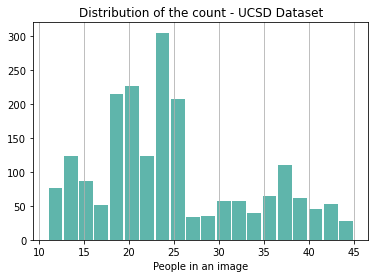

In [51]:
# histogram of the numer of person for each image

UCSD_count.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#2A9D8F', alpha=0.75)

plt.title('Distribution of the count - UCSD Dataset')
plt.xlabel('People in an image')
plt.ylabel('')
plt.grid(axis='y', alpha=0.35)

In [52]:
# let's see the mean, median and quantiles

UCSD_count.describe()

count    2000.000000
mean       24.748000
std         8.357597
min        11.000000
25%        19.000000
50%        23.000000
75%        30.000000
max        45.000000
dtype: float64

## Mall Dataset

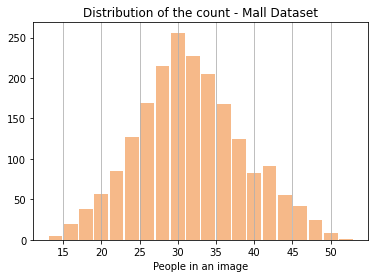

In [19]:
# histogram of the numer of person for each image

Mall_count.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#f4a261', alpha=0.75)

plt.title('Distribution of the count - Mall Dataset')
plt.xlabel('People in an image')
plt.ylabel('')
plt.grid(axis='y', alpha=0.35)

In [20]:
# let's see the mean, median and quantiles

Mall_count.describe()

count    2000.000000
mean       31.157500
std         6.945417
min        13.000000
25%        26.000000
50%        31.000000
75%        36.000000
max        53.000000
Name: count, dtype: float64

# Trial

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from scipy.io import loadmat
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import time
import skimage.measure

Number of people: 371


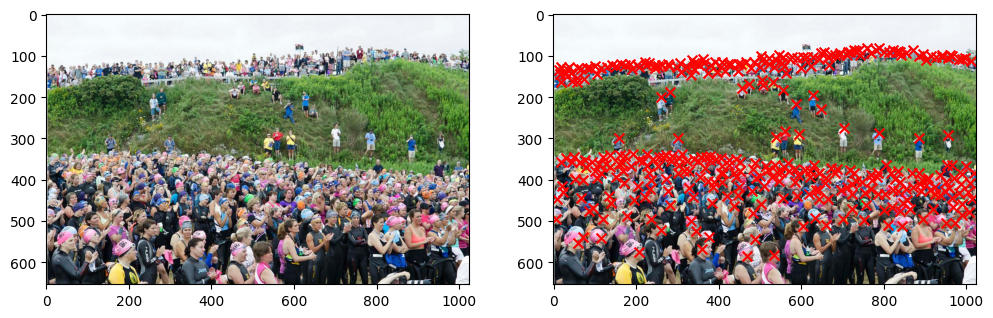

In [21]:
i100 = (cv2.cvtColor(cv2.imread("Trial/IMG_100.jpg"), cv2.COLOR_BGR2RGB))
h100 = loadmat("Trial/GT_IMG_100.mat")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(i100)
plt.subplot(1, 2, 2)
plt.imshow(i100)
print(f"Number of people: {len(h100['image_info'][0, 0][0, 0][0])}")

for x,y in h100["image_info"][0, 0][0, 0][0]:
    plt.scatter(round(x),round(y), s = 50, marker = "x", color = "r")

Number of people: 298


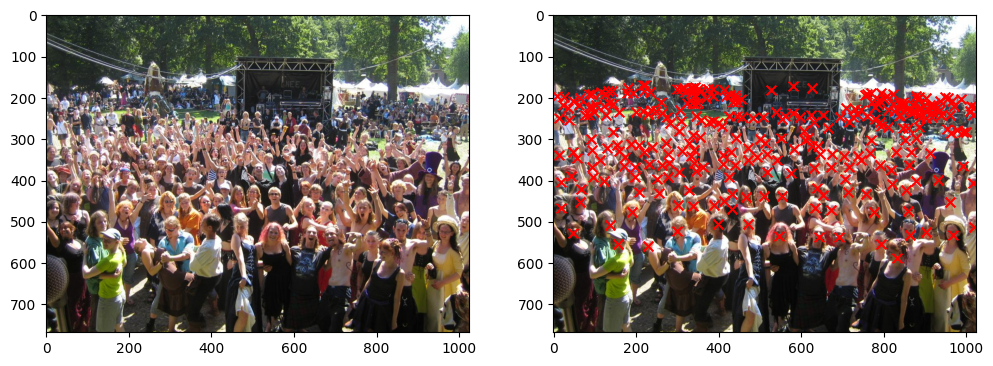

In [22]:
i101 = (cv2.cvtColor(cv2.imread("Trial/IMG_101.jpg"), cv2.COLOR_BGR2RGB))
h101 = loadmat("Trial/GT_IMG_101.mat")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(i101)
plt.subplot(1, 2, 2)
plt.imshow(i101)
print(f"Number of people: {len(h101['image_info'][0, 0][0, 0][0])}")

for x,y in h101["image_info"][0, 0][0, 0][0]:
    plt.scatter(round(x),round(y), s = 50, marker = "x", color = "r")

In [24]:
def density_map(image, heads):
    output = np.zeros(image.shape[:-1])
    x = heads["image_info"][0, 0][0, 0][0][:,0]
    y = heads["image_info"][0, 0][0, 0][0][:,1]
    
    for x_choord, y_choord in zip(x, y):
        density_i = np.zeros(image.shape[:-1])
        try:
            density_i[round(y_choord),round(x_choord)] = 1
        except:
            pass
        nearest_distance = np.min(np.linalg.norm(x_choord - y_choord))
        sigma = 0.3 * nearest_distance # beta = 0.3 suggested by MCNN paper
        kernel_size = 3
            
        density_i = cv2.GaussianBlur(density_i, (kernel_size,kernel_size), sigma)
        output += density_i
    return cv2.GaussianBlur(output, (51,51), sigma)

Time: 2.148758888244629


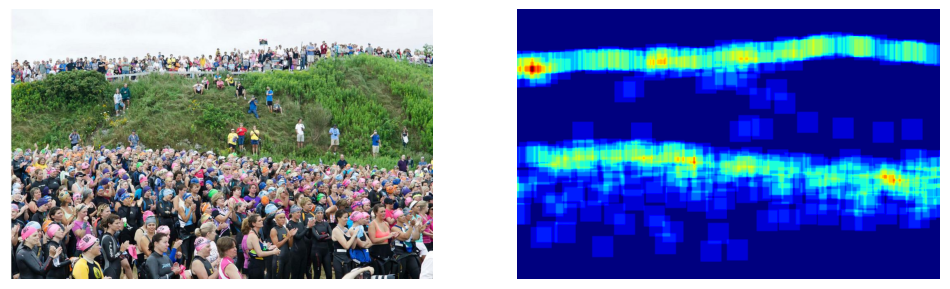

In [28]:
start = time.time()
ds_map = density_map(i100, h100)
print(f"Time: {time.time() - start}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(i100)
plt.subplot(1, 2, 2)
plt.axis("off")
_=plt.imshow(ds_map , cmap = cm.jet)

Time: 2.030758857727051


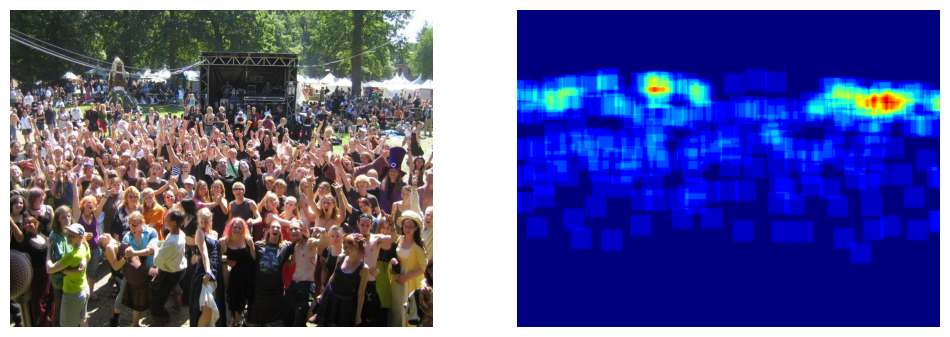

In [29]:
start = time.time()
ds_map = density_map(i101, h101)
print(f"Time: {time.time() - start}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(i101)
plt.subplot(1, 2, 2)
plt.axis("off")
_=plt.imshow(ds_map , cmap = cm.jet)